In [1]:
import torch
from torch.nn.functional import relu
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import configargparse


sys.path.append('../')
from configs import  DatasetParams
from data_loader import DataHandler
import mesh_tools as mt
import meshplot as mp

In [2]:
path_to_data = '../../../data/mipnerf360/'
# colmap_dir = os.path.join(path_to_data, scene, "sparse/0/")
device = 'cuda'

In [3]:
parser = configargparse.ArgParser()
dataset_args = DatasetParams(parser)

In [4]:
dataset_args.scene = 'bonsai'
dataset_args.data_path = path_to_data
split = 'train'
data_handler = DataHandler(
        dataset_args, rays_per_batch=0, device=device
)
# Setting up cameras to send to CUDA
if dataset_args.scene in ["garden", "stump", "bicycle"]:
        downsample = 4
elif dataset_args.scene in ["room", "bonsai", "counter", "kitchen"]:
        downsample = 2
elif dataset_args.scene in ["playroom", "drjohnson"]:
        downsample = 1
else:
        raise ValueError("Unknown scene")

data_handler.reload(
        split=split, downsample=downsample, use_depth_anything=True
    )

Loading data (255): 100%|██████████| 255/255 [00:03<00:00, 74.41it/s]


Computing depth maps and normal maps from pretrained model


  0%|          | 0/255 [00:00<?, ?it/s]Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda
100%|██████████| 255/255 [02:34<00:00,  1.65it/s]


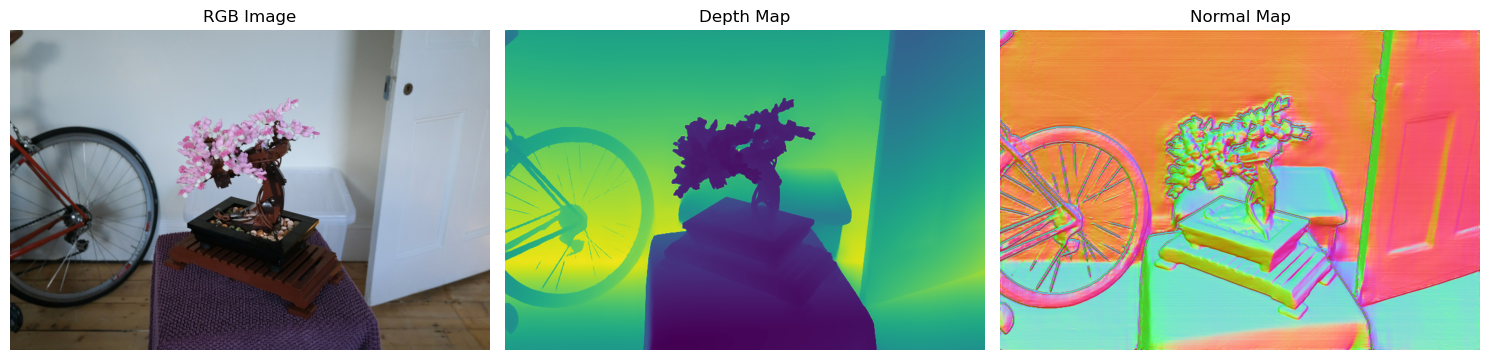

In [7]:
image_idx = 200
D_gt = data_handler.depth_maps[image_idx]
normal = data_handler.normal_maps[image_idx]
normal_mapped = (normal + 1) / 2  # Map normal to 0-1

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the RGB image
axs[0].imshow(data_handler.rgbs[image_idx])
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Display the depth map
im1 = axs[1].imshow(D_gt, cmap='viridis')
axs[1].set_title('Depth Map')
axs[1].axis('off')

# Display the normal map
im2 = axs[2].imshow(normal_mapped, cmap='viridis')
axs[2].set_title('Normal Map')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# # Put all alphas and betas in an array and plot their variance
# alphas = [image_idx_to_scale_factor[i][0] for i in image_idx_to_scale_factor.keys()]
# betas = [image_idx_to_scale_factor[i][1] for i in image_idx_to_scale_factor.keys()]

# import numpy as np

# # Create log-log scatter plot
# plt.scatter(alphas, betas, label='Data points')

# plt.xlim(np.mean(alphas) - 0.1, np.mean(alphas) + 0.1)
# plt.ylim(np.mean(betas) - 0.1, np.mean(betas) + 0.1)
# plt.xlabel('Log(Alpha)')
# plt.ylabel('Log(Beta)')
# plt.title('Log-Log Scatter plot of Alphas and Betas')
# plt.legend()
# plt.show()

# all_id_to_split_id = {data_handler.idx_map[i]:i for i in range(len(data_handler.idx_map))}
# # split_id_to_all_id = {v:k for k,v in all_id_to_split_id.items()}

# def create_image_to_points(data_handler):
#     # Create dict mapping image_id -> point3D_ids
#     image_to_points = {}
#     for point_id, values in data_handler.point3D_id_to_images.items():
#         for v in values:
            
#             image_id, pixel_id = v
#             if image_id not in all_id_to_split_id.keys(): continue

#             split_image_id = all_id_to_split_id[image_id]
#             if split_image_id not in image_to_points:
#                 image_to_points[split_image_id] = []
#             image_to_points[split_image_id].append([point_id, pixel_id])
#     return image_to_points

# def get_points_in_image(data_handler, image_to_points, image_idx):
#     # Get all points in image 1
#     image_points = image_to_points[image_idx]

#     points_in_image = []
#     # coords_of_points_in_image_1 = []
#     for i in range(len(image_points)):
#         pt_id = image_points[i][0]
#         point_id_in_image = data_handler.point3D_id_to_point3D_idx[pt_id]
#         point_in_im = data_handler.points3D[point_id_in_image]
#         points_in_image.append(point_in_im)
#         # coords_of_points_in_image_1.append(image_points[i][1])
#     # Turn to numpy
#     points_in_image = np.array(points_in_image)
#     # coords_of_points_in_image_1 = np.array(coords_of_points_in_image_1)

#     return points_in_image

# def get_points_in_uv_space(data_handler, points_in_image, image_idx):
#     # Transform points_in_image to view space
#     points_in_view_space = (torch.from_numpy(points_in_image) -  data_handler.c2ws[image_idx, :3, 3:4].T) @ data_handler.c2ws[image_idx, :3, :3]
    
#     points_in_uv_space = points_in_view_space @ data_handler.K.T
#     depth_sfm = points_in_uv_space[...,2].numpy().copy()
#     # disparity_sfm = 1.0 / (1e-6 + depth_sfm)

#     points_in_uv_space[:,0] = points_in_uv_space[:,0] / points_in_uv_space[:,2]
#     points_in_uv_space[:,1] = points_in_uv_space[:,1] / points_in_uv_space[:,2]
#     points_in_uv_space[:,2] = 1.0

#     return points_in_uv_space, depth_sfm


# def get_uv_points_in_image(data_handler, image_to_points, i):
#     points_in_image = get_points_in_image(data_handler, image_to_points, i)
#     points_in_uv_space, depth_sfm = get_points_in_uv_space(data_handler, points_in_image, i)
#     return points_in_uv_space, depth_sfm

# def get_depth_map(data_handler, image_idx):
#     # Get depth map of image
#     image = data_handler.rgbs[image_idx]
#     # Get depth
#     model_pretrained = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf",use_fast=True,device='cuda')
#     d_model_raw = relu(model_pretrained(to_pil_image(image.permute(2,0,1)))['predicted_depth'].cuda().squeeze())

#     return d_model_raw

# def get_gt_depth_labels(points_in_uv_space,d_model_raw):
#     y_coords = points_in_uv_space[:, 0].long().clamp(0, d_model_raw.shape[1] - 1)
#     x_coords = points_in_uv_space[:, 1].long().clamp(0, d_model_raw.shape[0] - 1)

#     disparity_gt = d_model_raw[x_coords, y_coords].cpu().numpy()

#     return disparity_gt

# def get_scaling_factor(x, y):
#     # solves y = ax + b
#     # Solving the linear system to find the scaling factor
#     sum_x = x.sum()
#     sum_y = y.sum()
#     sum_dot = (x * y).sum()
#     sum_x_sq = (x ** 2).sum()
#     n = x.shape[0]

#     a = np.array([sum_dot,sum_y])
#     M = np.array([[sum_x_sq, sum_x], [sum_x, n]])

#     alpha, beta = a @ np.linalg.inv(M)
#     return alpha, beta

# image_idx_to_scale_factor = {}
# IMAGE_TO_POINTS = create_image_to_points(data_handler)
# for i,image_idx in tqdm(enumerate(data_handler.idx_map),total=len(data_handler.idx_map)):
#     points_uv, D_sfm = get_uv_points_in_image(data_handler, IMAGE_TO_POINTS, i)
#     d_sfm = 1/D_sfm
#     d_raw = get_depth_map(data_handler, i)
#     d_gt = get_gt_depth_labels(points_uv, d_raw)
#     alpha, beta = get_scaling_factor(d_gt, d_sfm)


#     image_idx_to_scale_factor[i] = (alpha,beta)